In [1]:
import sys,os,copy, pickle, glob
import numpy as np
sys.path.append(os.path.abspath('../smodels'))
sys.path.append(os.path.abspath('../protomodels'))
from builder.protomodel import ProtoModel
from tester.predictor import Predictor
from tester.combiner import Combiner
from smodels.experiment.databaseObj import Database
from smodels.tools import runtime
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
from names import particleLabels
from sparticleNames import SParticleNames
import pandas as pd
# sns.set() #Set style
# sns.set_style('ticks')
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
# sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("deep"))


In [2]:
#Set colors:
namer = SParticleNames ( susy = False )
#Replace default colors:
colorPalette = 'deep' #Set color palette for particles, if None use default
colorDict = dict(zip(namer.names.keys(),sns.color_palette(palette=colorPalette,n_colors=len(namer.names))))

In [3]:
def getLikelihoods(protomodel,muvals,normalize=True):
    
    #Sort tpList
    critic = sorted(protomodel.tpList, key = lambda tp: tp[0], reverse = True)[0][2]

    #Combiner likelihood:
    combiner = Combiner(0)
    llhComb = np.array([combiner.getCombinedLikelihood(protomodel.bestCombo,mu) for mu in muvals])
    llhCombSM = combiner.getCombinedLikelihood(protomodel.bestCombo,0.)
    llhDict = {'Combined' : llhComb}
    llhDictSM = {'Combined' : llhCombSM}
    for tp in protomodel.bestCombo:
        llhDict[tp.expResult.globalInfo.id] = np.array([tp.getLikelihood(mu) for mu in muvals])
        llhDictSM[tp.expResult.globalInfo.id] = tp.getLikelihood(0.0)

    #Critic likelihood:
    if critic.getLikelihood(1.0) is not None:
        llhDictSM['Critic'] = critic.getLikelihood(0.0)
        llhDict['Critic'] = np.array([critic.getLikelihood(mu) for mu in muvals])
    else:
        llhDict['Critic'] = None
        llhDictSM['Critic'] = None
    llhDict['SM values'] = llhDictSM
    
    #Compute normalizations:
    if normalize:
        for key,llhd in llhDict.items():
            if key != 'SM values':
                norm = llhd.sum()
                llhDict[key] = llhd/norm
                llhDict['SM values'][key] *= 1/norm
    
    
    return llhDict

def getPredictions(protomodel,dbpath):
    
    #Compute predictions:
    pred = Predictor(walkerid=0,dbpath=dbpath)
    res = pred.predict(protomodel)

In [4]:
modelList = []
for f in glob.glob('../signal10fix/protomodel*pcl'):
    with open(f,'rb') as ff:
        protomodel = pickle.load(ff)
        protomodel.templateSLHA = '../protomodels/builder/templates/template1g.slha'
#         kold = protomodel.K
#         getPredictions(protomodel,os.path.join(os.path.dirname(f),'../official124_smodels200_signal10.pcl'))
        protomodel.step -= 1 #Set starting of step counter at zero instead of 1
#         knew = protomodel.K
#         if kold != knew and abs(kold-knew) > 0.1:
#             print(protomodel,protomodel.step,'kold=',kold,'knew=',knew)
#             break
        modelList.append(protomodel)
modelList = sorted(modelList, key = lambda p: p.step)        

In [5]:
#Get all particles which appears in all steps:
particles = []
for p in modelList:
    particles += p.unFrozenParticles()
particles = list(set(particles))

In [6]:
#Build useful dataset:
steps = np.array([p.step for p in modelList])
nparticles = np.array([len(p.unFrozenParticles()) for p in modelList])
Kvalues = np.array([p.K if (p.K and p.K > 0) else -1.0 for p in modelList])
Zvalues = np.array([p.Z if (p.Z and p.Z > 0) else -1.0 for p in modelList])
masses = dict([[pid,[]] for pid in particles])
for p in modelList:
    for pid in masses:
        if pid in p.masses:
            masses[pid].append(p.masses[pid])
        else:
#             masses[pid].append(np.nan)
            masses[pid].append(-100.0)
for pid in masses:
    masses[pid] = np.array(masses[pid])
dataDict = {'step' : steps, 'K' : Kvalues, 'Z' : Zvalues, 
                   'nparticles' : nparticles}
dataDict.update(masses) 
df = pd.DataFrame(dataDict)

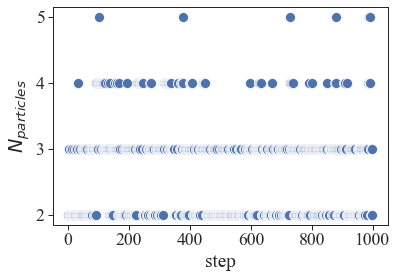

In [7]:
sns.scatterplot(x='step',y='nparticles',data=df, s=100)
plt.ylabel(r'$N_{particles}$')
plt.xlabel('step')
plt.show()

In [8]:
print('Max K = %1.2f at step %i' %(Kvalues[np.argmax(Kvalues)],np.argmax(Kvalues)))
print(modelList[np.argmax(Kvalues)])

Max K = 1.76 at step 556
ProtoModel (XZ1,Xd): K = 1.76, Z = 2.02


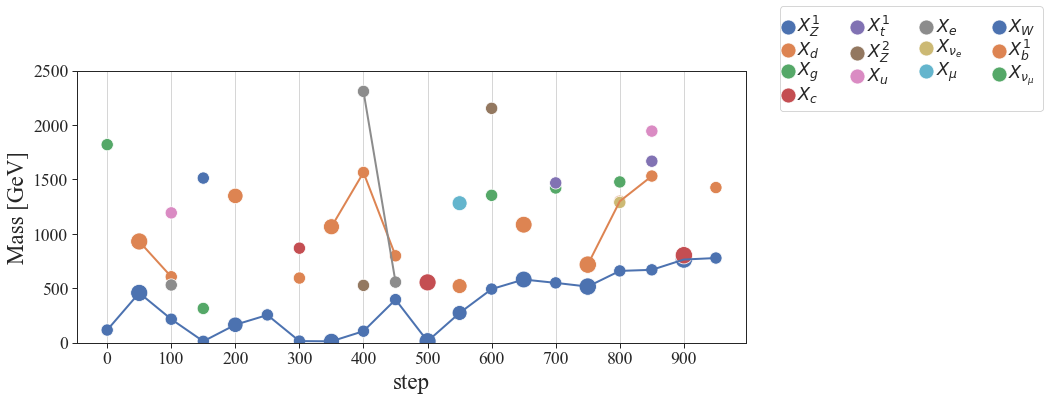

In [13]:
fig = plt.figure(figsize=(12, 5))

nsteps = 50
stepmax = len(df)
stepmin = 0

pids = sorted(masses.keys(), key = lambda pid: np.sum(np.where(masses[pid][stepmin:stepmax:nsteps] <= 0)))
for pid in pids:
    if max(masses[pid][stepmin:stepmax:nsteps]) <= 0.0: continue
    sns.scatterplot(x='step',y=pid,data=df[stepmin:stepmax:nsteps], size='K', sizes = (150,300),
                    label=r'$%s$' %(particleLabels[pid]), legend=False)
    m = np.where(masses[pid] > 0, masses[pid],np.nan) #Fix for avoid plotting to negative values
    plt.plot(df['step'][stepmin:stepmax:nsteps],m[stepmin:stepmax:nsteps],'-',linewidth=2)

plt.ylim(0.,2500.0)
plt.xlabel('step', fontsize=23)
plt.ylabel('Mass [GeV]', fontsize=23)
plt.xticks(df['step'][stepmin:stepmax:2*nsteps])
# plt.xlim(-5,198)
plt.grid(axis='x') 
plt.legend(loc=(1.05,0.85),framealpha=1.0,ncol=4,labelspacing=0.05,handlelength=0.1,handletextpad=0.5)
# plt.tight_layout()
plt.show()

In [21]:
df[1000022].max()

861.8112546711893

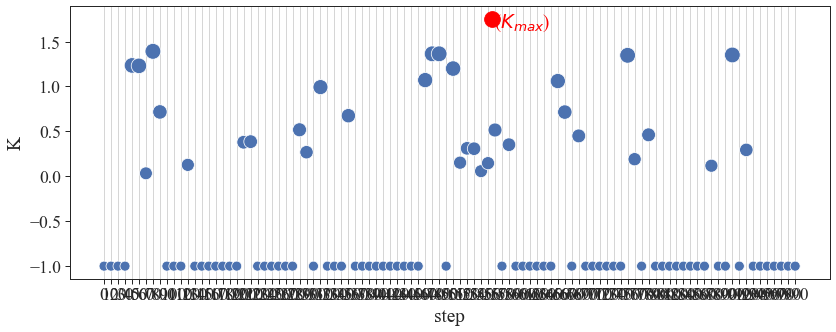

In [14]:
fig = plt.figure(figsize=(12, 5))
nsteps = 10
stepmax = len(df)
stepmin = 0
sns.scatterplot(x='step',y='K',data=df[stepmin:stepmax:nsteps],size='K',legend=False,sizes=(100,250))
plt.scatter([steps[np.argmax(Kvalues)]],[Kvalues.max()],marker='o',s=250,c='red')
plt.text(x=steps[np.argmax(Kvalues)]+2,y=0.95*Kvalues.max(),s=r'($K_{max}$)',c='red')
plt.xlabel('step')
plt.ylabel('K')
plt.xticks(df['step'][stepmin:stepmax:nsteps])
# plt.xlim(170,200)
plt.grid(axis='x') 
plt.tight_layout()
plt.show()

In [15]:
print('Max K = %1.2f at step %i' %(Kvalues[np.argmax(Kvalues)],np.argmax(Kvalues)))
protomodel = modelList[np.argmax(Kvalues)]
kold = protomodel.K
getPredictions(protomodel,os.path.join(os.path.dirname(f),'../official124_smodels200_signal10.pcl'))
knew = protomodel.K
if kold != knew and abs(kold-knew) > 0.1:
    print(protomodel,protomodel.step,'kold=',kold,'knew=',knew)


Max K = 1.76 at step 556
Skipping result for: ATLAS-SUSY-2013-02
Skipping result for: ATLAS-SUSY-2013-02


Skipping result for: CMS-SUS-13-019
Skipping result for: CMS-SUS-13-019
[combine:0] selected predictions down via SRs from 172 to 9.
[combine:0] sorting out subsets, reduced 80 -> 16 combinations.


combination #16/16 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


In [16]:
printSteps = [np.argmax(Kvalues)]
muvals = np.linspace(-10,10,500)
llhDictList = []
for stp in printSteps:
    protomodel = [p for p in modelList if p.step == stp][0]
    print(protomodel)
    llhDict = getLikelihoods(protomodel,muvals)
    llhDictList.append(llhDict)

ProtoModel (XZ1,Xd): K = 1.76, Z = 2.02


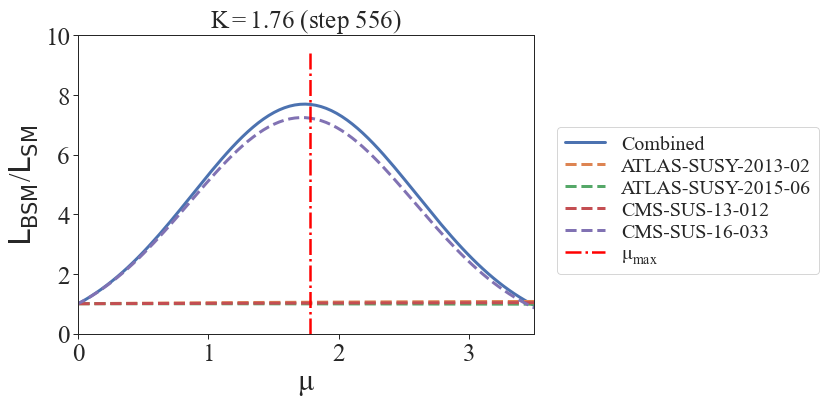

In [17]:
f, axarr = plt.subplots(1, 1,figsize=(12, 6))
irow, icolumn = 0,0
for i,stp in enumerate(printSteps):
    ax = axarr
    protomodel = [p for p in modelList if p.step == stp][0]
    llhDict = llhDictList[i]
    for key,val in llhDict.items():
        if key == 'SM values': continue
        if key == 'Critic': continue
        if key == 'Combined': ls = '-'
        else: ls = '--'
        ax.plot(muvals,val/llhDict['SM values'][key],label=key,linestyle=ls,linewidth=3)
    
    ax.axvline(x=protomodel.mumax,ymax=0.95,c='red',linestyle='-.',label=r'$\mathdefault{\mu_{max}}$',
                   linewidth=2.5)
    tit = r'$'
    tit += '\mathdefault{K = %1.2f}$ (step %i)' %(protomodel.K,protomodel.step)
    ax.set_title(tit,fontsize=25)
    ax.set_xticks(np.linspace(0,5,6))
    icolumn += 1
    ax.set_xlabel(r'$\mathdefault{\mu}$',fontsize=30)
    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=25)
    if icolumn == 1:
        ax.set_ylabel(r'$\mathdefault{\mathrm{L}_{\mathrm{BSM}}/\mathrm{L}_{\mathrm{SM}}}$',fontsize=30)
        ax.legend(loc=(1.05,0.2),framealpha=1,fontsize=20,labelspacing=0.2)
    else:
        ax.set_yticks([])
    ax.set_xlim(0,3.5)
    ax.set_ylim(0,10)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.02)
plt.show()

In [ ]:
protomodel = [p for p in modelList if p.step == 99][0]
print(protomodel)
print(protomodel.masses)

In [ ]:
for tp in protomodel.tpList:
    print(tp[2],tp[2].txnames)

In [ ]:
for tp in protomodel.bestCombo:
    print(tp,tp.txnames,tp.dataType())